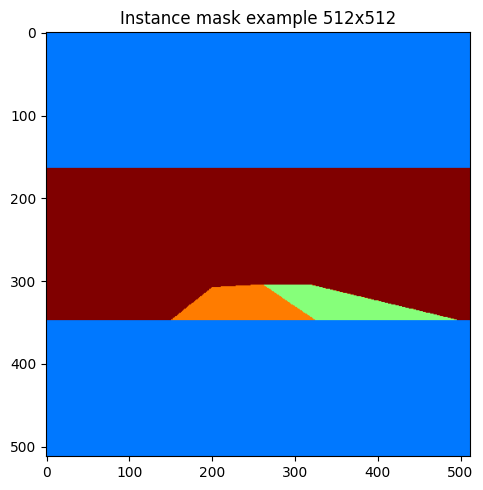

In [12]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

lines = r'..\..\visualization_resources\example.lines.txt'
image = r'..\..\visualization_resources\example.jpg'

def data_process_mask(lines_file, image_file):
    mask_wdith, mask_height, _ = cv.imread(image_file).shape

    lines = []

    mask = np.zeros((mask_wdith, mask_height), dtype=np.uint8)

    line_id = lane_id = coords_first_id = coords_second_id = 0

    with open(lines_file, 'r') as file:
        lines = [list(map(int, map(float, line.split()))) for line in file]
    
    while line_id != len(lines) - 1:
        coords_first_id = coords_second_id = 0

        while coords_first_id + 4 <= len(lines[line_id]) or coords_second_id + 4 <= len(lines[line_id + 1]):
            x1, y1 = lines[line_id][coords_first_id], lines[line_id][coords_first_id + 1]
            x2, y2 = lines[line_id][coords_first_id + 2], lines[line_id][coords_first_id + 3]
            x3, y3 = lines[line_id + 1][coords_second_id], lines[line_id + 1][coords_second_id + 1]
            x4, y4 = lines[line_id + 1][coords_second_id + 2], lines[line_id + 1][coords_second_id + 3]

            cv.fillPoly(mask, [np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]])], lane_id + 1, lineType = cv.LINE_AA)

            if coords_first_id + 4 < len(lines[line_id]):
                    coords_first_id += 2
            
            if coords_second_id + 4 < len(lines[line_id + 1]):
                    coords_second_id += 2

            if coords_first_id + 4 == len(lines[line_id]) and coords_second_id + 4 == len(lines[line_id + 1]):
                    x1, y1 = lines[line_id][coords_first_id], lines[line_id][coords_first_id + 1]
                    x2, y2 = lines[line_id][coords_first_id + 2], lines[line_id][coords_first_id + 3]
                    x3, y3 = lines[line_id + 1][coords_second_id], lines[line_id + 1][coords_second_id + 1]
                    x4, y4 = lines[line_id + 1][coords_second_id + 2], lines[line_id + 1][coords_second_id + 3]

                    cv.fillPoly(mask, [np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]])], lane_id + 1, lineType = cv.LINE_AA)

                    break

        line_id += 1

        lane_id += 1

    return np.stack([mask] * 3, axis=-1), lane_id

def resize_and_pad_mask(mask, target_size=512, pad_value=255):
    mask = mask[:, :, 0]

    original_height, original_width = mask.shape

    scale = min(target_size / original_height, target_size / original_width)
    new_height = int(round(original_height * scale))
    new_width = int(round(original_width * scale))

    resized = cv.resize(mask, (new_width, new_height), interpolation=cv.INTER_NEAREST)

    pad_top = (target_size - new_height) // 2
    pad_bottom = target_size - new_height - pad_top
    pad_left = (target_size - new_width) // 2
    pad_right = target_size - new_width - pad_left

    padded = cv.copyMakeBorder(
        resized,
        pad_top, pad_bottom,
        pad_left, pad_right,
        borderType=cv.BORDER_CONSTANT,
        value=pad_value
    )

    return padded.astype(np.uint8)

mask, lanes_num = data_process_mask(lines, image)

mask_res = resize_and_pad_mask(mask)

colored_mask = mask_res.copy()


colored_mask = cv.applyColorMap(mask_res * (255 // (lanes_num + 2)), cv.COLORMAP_JET)

plt.figure(figsize=(5, 5))

plt.subplot()
plt.title('Instance mask example 512x512')
plt.imshow(colored_mask)

plt.tight_layout()
plt.show()